In [6]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from xmitgcm import utils
from xmitgcm import open_mdsdataset
from xgcm import Grid
from xhistogram.xarray import histogram
from dask.diagnostics import ProgressBar

In [7]:
dS = 0.001
dT = 0.01
Sbins = np.arange(34.9, 35.1+dS/2., dS)
Tbins = np.arange(3.25, 5.25+dT/2., dT)

In [8]:
stats = xr.open_dataset("data/tracer_stats.nc")

In [23]:
import gsw

z0 = -1800.
stats['RHO_bin'] = gsw.sigma2(stats['SALT_bin'], gsw.CT_from_pt(stats['SALT_bin'], stats['THETA_bin']))

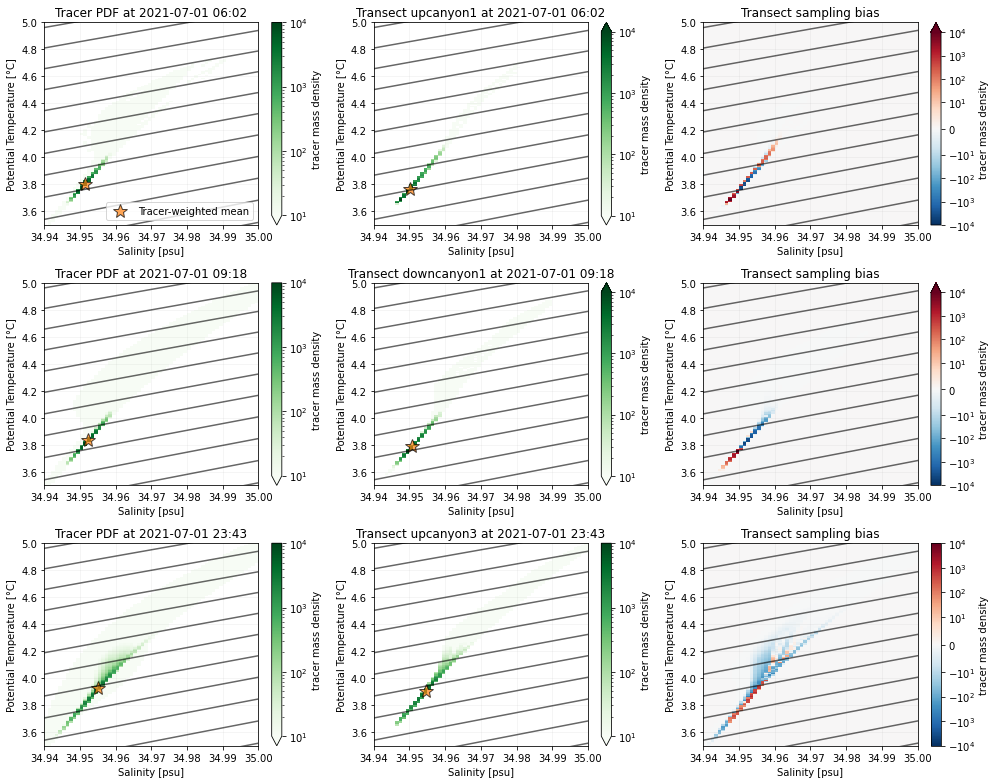

In [28]:
fig = plt.figure(figsize=(14, 11))

for i, tran_name in enumerate(["upcanyon1", "downcanyon1", "upcanyon3"]):

    tran = xr.open_dataset(f"data/simulated_transects/{tran_name}_realistic.nc")
    dV = tran['drF']*tran['rA']
    
    with ProgressBar():
        tracer_hist = histogram(tran.SALT, tran.THETA, bins=[Sbins, Tbins], dim=['cast', 'Z'], weights=tran['TRAC01']*dV, density=True).compute()

        first_moment_T = (tran['THETA']*tran['TRAC01']*dV).sum(['cast', 'Z'])/(tran['TRAC01']*dV).sum(['cast', 'Z']).compute()
        first_moment_S = (tran['SALT']*tran['TRAC01']*dV).sum(['cast', 'Z'])/(tran['TRAC01']*dV).sum(['cast', 'Z']).compute()
        first_moment_XC = (tran['XC']*tran['TRAC01']*dV).sum(['cast', 'Z'])/(tran['TRAC01']*dV).sum(['cast', 'Z']).compute()
        first_moment_YC = (tran['YC']*tran['TRAC01']*dV).sum(['cast', 'Z'])/(tran['TRAC01']*dV).sum(['cast', 'Z']).compute()
        first_moment_Z = (tran['Z']*tran['TRAC01']*dV).sum(['cast', 'Z'])/(tran['TRAC01']*dV).sum(['cast', 'Z']).compute()

    stats_tran = xr.Dataset({
        'TR01_TSMASSPDF': tracer_hist,
        'THETA_bar': first_moment_T,
        'SALT_bar': first_moment_S,
        'XC_bar': first_moment_XC,
        'YC_bar': first_moment_YC,
        'Z_bar': first_moment_Z,
    })

    stats_tmp = stats.interp(time=tran['time'].mean())

    ### Full solution
    ax=plt.subplot(3,3,1+3*i)
    pc = stats_tmp['TR01_TSMASSPDF'].plot(ax=ax, x="SALT_bin", y='THETA_bin', cmap="Greens", norm=matplotlib.colors.LogNorm(vmax=1e4, vmin=1e1))
    pc.colorbar.set_label("tracer mass density")
    plt.plot(stats_tmp['SALT_bar'], stats_tmp['THETA_bar'], "C1*", markersize=15, mec="k", alpha=0.7)
    cs = (
        (stats_tmp['RHO_bin']).sel(SALT_bin=slice(34.92, 35.02))
        .plot.contour(ax=ax, x="SALT_bin", y='THETA_bin', colors="k", alpha=0.6, levels=np.arange(36, 37, 0.025))
    )
    plt.grid(True, alpha=0.15)
    plt.xlim(34.94, 35.0)
    plt.ylim(3.5, 5)
    
    short_date = str(stats_tmp['time'].values)[0:16].replace("T", " ")
    plt.title(f"Tracer PDF at {short_date}")
    
    if i==0:
        plt.plot([], [], "C1*", markersize=15, mec="k", alpha=0.7, label="Tracer-weighted mean")
        plt.legend(loc="lower right")


    ### Subsampled
    ax=plt.subplot(3,3,2+3*i)
    pc = stats_tran['TR01_TSMASSPDF'].plot(ax=ax, x="SALT_bin", y='THETA_bin', cmap="Greens", norm=matplotlib.colors.LogNorm(vmax=1e4, vmin=1e1))
    pc.colorbar.set_label("tracer mass density")
    plt.plot(stats_tran['SALT_bar'], stats_tran['THETA_bar'], "C1*", markersize=15, mec="k", alpha=0.7)
    cs = (
        (stats_tmp['RHO_bin']).sel(SALT_bin=slice(34.92, 35.02))
        .plot.contour(ax=ax, x="SALT_bin", y='THETA_bin', colors="k", alpha=0.6, levels=np.arange(36, 37, 0.025))
    )
    plt.grid(True, alpha=0.15)
    plt.xlim(34.94, 35.0)
    plt.ylim(3.5, 5)
    plt.title(f"Transect {tran_name} at {short_date}")

    ### Difference
    ax=plt.subplot(3,3,3+3*i)
    pc = (stats_tran['TR01_TSMASSPDF'] - stats_tmp['TR01_TSMASSPDF']).plot(
        ax=ax, x="SALT_bin", y='THETA_bin',
        cmap="RdBu_r", norm=matplotlib.colors.SymLogNorm(linthresh=1e1, vmin=-1e4, vmax=1e4)
    )
    pc.colorbar.set_label("tracer mass density")
    cs = (
        (stats_tmp['RHO_bin']).sel(SALT_bin=slice(34.92, 35.02))
        .plot.contour(ax=ax, x="SALT_bin", y='THETA_bin', colors="k", alpha=0.6, levels=np.arange(36, 37, 0.025))
    )

    plt.grid(True, alpha=0.15)
    plt.xlim(34.94, 35.0)
    plt.ylim(3.5, 5)
    plt.title("Transect sampling bias")

plt.tight_layout()